# Libraries and Packages

In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Functions

In [2]:
def round_up_to_nearest_five_minutes(ts):
    # Parse the timestamp
    dt = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
    
    # Calculate minutes to add to round up to the nearest 5 minutes
    minutes_to_add = (5 - dt.minute % 5) % 5
    if minutes_to_add == 0 and dt.second == 0:
        # If exactly on a 5 minute mark and second is 0, no need to add time
        minutes_to_add = 5
    
    # Add the necessary minutes
    new_dt = dt + timedelta(minutes=minutes_to_add)
    
    # Return the new timestamp in the same format
    return new_dt.strftime( "%d-%m-%Y %H:%M:%S")

In [3]:
# Need to set the 
def read_ohio(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts'])
            entry0['ts'] = adjusted_ts
        ts = entry0['ts']
        entry0['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts = entry['ts']
            if round == True:
                adjusted_ts = round_up_to_nearest_five_minutes(ts)
                entry['ts'] = adjusted_ts
            entry['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            res.append([entry])
    return res


In [4]:
def transfer_into_table(glucose):
    glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

    # Create the multi-channel database
    g_data = []
    for timestamp in glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': glucose_dict[timestamp],
            # 'meal_type': None,
            # 'meal_carbs': 0
        }
        
        g_data.append(record)

    # Create DataFrame
    glucose_df = pd.DataFrame(g_data)

    # Convert glucose values to numeric type for analysis
    glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])
    glucose_df['glucose_value'] = glucose_df['glucose_value'] / 100 # Shrink to its 1/100 for scaling

    return glucose_df

In [5]:
def segement_data_as_1hour(data):
    df = pd.DataFrame(data)

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff()

    # Identify large gaps
    df['new_segment'] = df['time_diff'] > pd.Timedelta(hours=1)

    # Find indices where new segments start
    segment_starts = df[df['new_segment']].index

    # Initialize an empty dictionary to store segments
    segments = {}
    prev_index = 0

    # Loop through each segment start and slice the DataFrame accordingly
    for i, start in enumerate(segment_starts, 1):
        segments[f'segment_{i}'] = df.iloc[prev_index:start].reset_index(drop=True)
        prev_index = start

    # Add the last segment from the last gap to the end of the DataFrame
    segments[f'segment_{len(segment_starts) + 1}'] = df.iloc[prev_index:].reset_index(drop=True)

    # Optionally remove helper columns from each segment
    for segment in segments.values():
        segment.drop(columns=['time_diff', 'new_segment'], inplace=True)
    
    return segments

In [6]:
def detect_missing_and_spline_interpolate(segments):
    for sequence in segments:
        # sequence = "segment_3"
        detected_missing = 0
        for ts in range(len( segments[sequence]['timestamp'])-1):
            if segments[sequence]['timestamp'][ts+1] - segments[sequence]['timestamp'][ts] > timedelta(minutes = 6):
                print(sequence)
                print("before: ", segments[sequence]['timestamp'][ts])
                print("after: ", segments[sequence]['timestamp'][ts+1])
                detected_missing = 1
            
        if detected_missing == 1:
            datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
            reference_time = min(segments[sequence]['timestamp'])

            # Convert datetime objects to the number of seconds since the reference time
            datetime_seconds_since_start = [((dt - reference_time).total_seconds())/60 for dt in datetime_list] # Make it into minute
            original_timestamp_in_segement = [((dt - reference_time).total_seconds())/60 for dt in segments[sequence]['timestamp']]

            x = original_timestamp_in_segement
            y = np.array(segments[sequence]['glucose_value'])
            cs = CubicSpline(x, y)
            xs = datetime_seconds_since_start

            interpolated_xs = cs(xs)
            time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')

            # Create DataFrame from the time index and glucose values
            df_interpolated = pd.DataFrame({'timestamp': time_index_interpolated, 'glucose_value': interpolated_xs})
            segments[sequence] = df_interpolated

    return segments

In [7]:
# Function to align and update segments with meal data
def find_closest_glucose_index(glucose_df, meal_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - meal_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carbs'] = 0

        for index, meal_row in meal_df.iterrows():
            meal_time = meal_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, meal_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'carbs'] = int(meal_row['carbs'])/100
                meal_df.loc[index, 'assigned'] = True


    return segments

In [8]:
# Function to align and update segments with meal data
def update_segments_with_basal(segments, basal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, basal_row in basal_df.iterrows():
                if basal_row['ts'] <= row['timestamp'] < (basal_row['end_ts'] if pd.notna(basal_row['end_ts']) else pd.Timestamp('2099-12-31')):
                    segment_df.at[i, 'basal_rate'] = basal_row['value']
                    break

    return segments

In [9]:
# Read in bolus and temp basal information
# Need to set the 
def read_ohio_bolus_tempbasal(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        if len(item) == 0:
            continue  # Skip if the item has no children
            
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_begin'])
            entry0['ts_begin'] = adjusted_ts
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_end'])
            entry0['ts_end'] = adjusted_ts
        
        entry0['ts_begin'] = datetime.strptime(entry0['ts_begin'], "%d-%m-%Y %H:%M:%S")
        entry0['ts_end'] = datetime.strptime(entry0['ts_end'], "%d-%m-%Y %H:%M:%S")

        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            ts_begin = entry['ts_begin']
            ts_end = entry['ts_end']
            if round == True:
                adjusted_ts_begin = round_up_to_nearest_five_minutes(ts_begin)
                entry['ts_end'] = adjusted_ts_begin
                adjusted_ts_end = round_up_to_nearest_five_minutes(ts_end)
                entry['ts_end'] = adjusted_ts_end
            entry['ts_begin'] = datetime.strptime(entry['ts_begin'], "%d-%m-%Y %H:%M:%S")
            entry['ts_end'] = datetime.strptime(entry['ts_end'], "%d-%m-%Y %H:%M:%S")
            if category == "bolus":
                if entry['ts_begin'] != entry['ts_end']:
                    print("Unequal: begin: " + str(entry['ts_begin']) + "end: " + str(entry['ts_end']))
            res.append([entry])
    return res

In [10]:
# Function to align and update segments with meal data
def find_closest_glucose_index(glucose_df, bolus_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - bolus_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_bolus(segments, bolus_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['bolus_dose'] = 0

        for index, bolus_row in bolus_df.iterrows():
            bolus_time = bolus_row['ts_begin']
            closest_glucose_idx = find_closest_glucose_index(segment_df, bolus_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'bolus_dose'] = float(bolus_row['dose']) /10
                bolus_df.loc[index, 'assigned'] = True


    return segments

In [11]:
# Function to align and update segments with meal data
def update_segments_with_tempbasal(segments, tempbasal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        # segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, tempbasal_row in tempbasal_df.iterrows():
                if tempbasal_row['ts_begin'] <= row['timestamp'] < tempbasal_row['ts_end']:
                    segment_df.at[i, 'basal_rate'] = tempbasal_row['value']
                    break

    return segments


In [12]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 1)
    label_upper_percentile = np.percentile(labels_list, 99)
    # label_lower_percentile = min(labels_list)
    # label_upper_percentile = max(labels_list)
    print("The label_lower_percentile is ", label_lower_percentile)
    print("The label_upper_percentile is ", label_upper_percentile)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(0)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((255/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile)))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(255)
    return transformed_labels

In [21]:
history_len = 7

In [22]:
def prepare_dataset(segments, ph):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history_len+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+15
            features = segment_df.loc[i:i+history_len, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values#.flatten()
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+history_len+ph, 'glucose_value'] - segment_df.loc[i+7, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history_len+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    new_labels_list = label_delta_transform(labels_list)    
    print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, new_labels_list, raw_glu_list
    
    # # Convert lists to PyTorch tensors
    # features_tensor = torch.tensor(features_list, dtype=torch.float32)
    # labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D
    
    # return TensorDataset(features_tensor, labels_tensor)

# Implementation

## Traininig

In [23]:
ph = 6

In [ ]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/591-ws-training.xml"
glucose = read_ohio(filepath, "glucose_level", False)
glucose_df = transfer_into_table(glucose)
segments = segement_data_as_1hour(glucose_df)
interpolated_segements = detect_missing_and_spline_interpolate(segments)

#Include meal:
meal = read_ohio(filepath, "meal", False)
flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist
# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)
meal_df['assigned'] = False
# Update the segments with meal data
meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


#Include basal:
basal = read_ohio(filepath, "basal", False)
flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist
# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)
basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


# Include bolus:
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)
flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist
# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)
bolus_df['assigned'] = False
bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)


# Include temp basal
tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)
flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist
# Convert to DataFrame
tempbasal_df = pd.DataFrame(flattened_tempbasal_data)
tempbasal_df['assigned'] = False
final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

# Prepare for training
features_list, labels_list, new_labels_list, raw_glu_list = prepare_dataset(final_updated_segments, ph)

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## WaveNet NN

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=1+dilation - 2^(dilation-1))
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=dilation)
        self.res_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        # print("shape of x: ", x.shape)
        out = F.relu(self.conv1(x))
        # print("shape of first out: ", out.shape)
        out = F.relu(self.conv2(out))
        # print("shape of second out: ", out.shape)
        res = self.res_conv(x)
        # print("shape of res: ", res.shape)
        return out + res

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, dilations):
        super(WaveNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 32, kernel_size=2, padding=1)
        self.blocks = nn.ModuleList([WaveNetBlock(32, dilation) for dilation in dilations])
        self.final_conv1 = nn.Conv1d(32, 128, kernel_size=2, padding=0)
        self.final_conv2 = nn.Conv1d(128, 256, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        for block in self.blocks:
            # print("enter the block loop")
            x = block(x)
        x = F.relu(self.final_conv1(x))
        x = F.relu(self.final_conv2(x))
        x = x[:, :, -1]  # Get the last time step
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_channels = 4  # Number of features
output_channels = 1  # Predicting a single value (glucose level)
num_blocks = 4  # Number of WaveNet blocks
dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8

model = WaveNet(input_channels, output_channels, num_blocks, dilations)
print(model)

# Example of how to define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)


WaveNet(
  (initial_conv): Conv1d(4, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (blocks): ModuleList(
    (0): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (1): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (2): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (3): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
      (conv2): Conv1d(32, 32, kernel_size=(2

In [73]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results

Epoch 1, Validation Loss: 0.18034554111963028
Epoch 2, Validation Loss: 0.16740648663493202
Epoch 3, Validation Loss: 0.16263805883799626
Epoch 4, Validation Loss: 0.16206016867448958
Epoch 5, Validation Loss: 0.16352130929419004
Epoch 6, Validation Loss: 0.16485734061023002
Epoch 7, Validation Loss: 0.1655248437925954
Epoch 8, Validation Loss: 0.16580837194616085
Epoch 9, Validation Loss: 0.1659074158010566
Epoch 10, Validation Loss: 0.1659618918920922
Epoch 11, Validation Loss: 0.16598976005265928
Epoch 12, Validation Loss: 0.1660454235970974
Epoch 13, Validation Loss: 0.1660853074041798
Epoch 14, Validation Loss: 0.16611632299335563
Epoch 15, Validation Loss: 0.1661662362406359
Epoch 16, Validation Loss: 0.16620930814978613
Epoch 17, Validation Loss: 0.1662470381227596
Epoch 18, Validation Loss: 0.16627155819579081
Epoch 19, Validation Loss: 0.16630268315716154
Epoch 20, Validation Loss: 0.16632880822084295


In [74]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs.permute(0, 2, 1))
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 0.3426363468170166


## Testing

In [ ]:
filepath_test = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/test/591-ws-testing.xml"
glucose_test = read_ohio(filepath, "glucose_level", False)
glucose_df_test = transfer_into_table(glucose_test)
segments_test = segement_data_as_1hour(glucose_df_test) # segment
interpolated_segements_test = detect_missing_and_spline_interpolate(segments_test) #spline interpolate


# Include meal info
meal_test = read_ohio(filepath_test, "meal", False)
flattened_meal_data_test = [item[0] for item in meal_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
meal_df_test = pd.DataFrame(flattened_meal_data_test)
meal_df_test['assigned'] = False
meal_updated_segments_test = update_segments_with_meals(interpolated_segements_test, meal_df_test)


# Include basal
basal_test = read_ohio(filepath_test, "basal", False)
flattened_basal_data_test = [item[0] for item in basal_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
basal_df_test = pd.DataFrame(flattened_basal_data_test)
basal_df_test['assigned'] = False
basal_df_test['end_ts'] = basal_df_test['ts'].shift(-1)
basal_updated_segments_test = update_segments_with_basal(meal_updated_segments_test, basal_df_test)


# Include bolus
bolus_test = read_ohio_bolus_tempbasal(filepath_test, "bolus", False)
flattened_bolus_data_test = [item[0] for item in bolus_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
bolus_df_test = pd.DataFrame(flattened_bolus_data_test)
bolus_df_test['assigned'] = False
bolus_updated_segments_test = update_segments_with_bolus(basal_updated_segments_test, bolus_df_test)


# Include temp basal
tempbasal_test = read_ohio_bolus_tempbasal(filepath_test, "temp_basal", False)
flattened_tempbasal_data_test = [item[0] for item in tempbasal_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
tempbasal_df_test = pd.DataFrame(flattened_tempbasal_data_test)
tempbasal_df_test['assigned'] = False
final_updated_segments_test = update_segments_with_tempbasal(bolus_updated_segments_test, tempbasal_df_test)


features_list_test, labels_list_test, new_labels_list_test, raw_glu_list_test = prepare_dataset(final_updated_segments_test,ph)

## Input test data to the trained model and generate result

In [76]:
features_array_test = np.array(features_list_test)
labels_array_test = np.array(raw_glu_list_test)

X_test_tensor = torch.tensor(features_array_test, dtype=torch.float32)
y_test_tensor = torch.tensor(labels_array_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.permute(0, 2, 1))
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on test set: {rmse}')

RMSE on test set: 0.32470837235450745


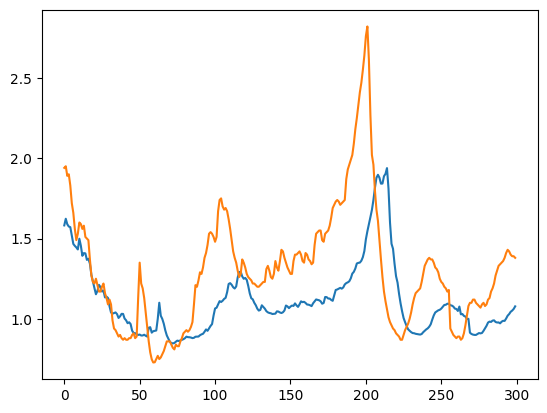

In [40]:
plt.plot(predictions[:300])
plt.plot(actuals[:300])